# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

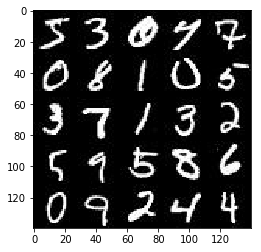

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

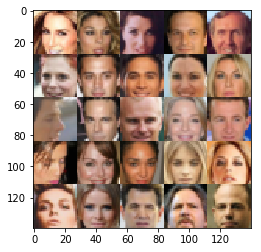

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


C:\Users\m1312932\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\ipykernel\__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
            
    input_real = tf.placeholder(name = "input_real", shape=(None, image_height, image_width, image_channels), dtype=tf.float32)
    input_z = tf.placeholder(name = "input_z", shape=(None, z_dim), dtype=tf.float32)
    learning_rate = tf.placeholder(name="learning_rate", dtype=tf.float32)

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\Users\\m1312932\\AppData\\Local\\Continuum\\Anaconda3\\envs\\dlnd-tf-lab\\lib\\runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\Users\\m1312932\\AppData\\Local\\Continuum\\Anaconda3\\envs\\dlnd-tf-lab\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\Users\\m1312932\\AppData\\Local\\Continuum\\Anaconda3\\envs\\dlnd-tf-lab\\lib\\site-packages\\ipykernel\\__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "C:\\Users\\m1312932\\AppData\\Local\\Continuum\\Anaconda3\\envs\\dlnd-tf-lab\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\Users\\m131293

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * conv1, conv1)
                
        conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * bn1, bn1)
                
        conv3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * bn2, bn2)
        
        dim = int(relu3.shape[1]*relu3.shape[2]*relu3.shape[3])
        
        flattern = tf.reshape(relu3, (-1, dim))
        logits = tf.layers.dense(flattern, 1)
        output = tf.sigmoid(logits)

    return output, logits
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse= not is_train):
        
        alpha = 0.2
        
        fc1 = tf.layers.dense(z, 7*7*512)
        
        fc1 = tf.reshape(fc1, (-1, 7, 7, 512))
        fc1 = tf.layers.batch_normalization(fc1, training=is_train)
        fc1 = tf.maximum(alpha * fc1, fc1)
                        
        conv_t1 = tf.layers.conv2d_transpose(fc1, 256, 5, strides=2, padding='same')
        conv_t1 = tf.layers.batch_normalization(conv_t1, training=is_train)
        conv_t1 = tf.maximum(alpha * conv_t1, conv_t1)
                              
        logits = tf.layers.conv2d_transpose(conv_t1, out_channel_dim, 5, strides=2, padding='same')
                               
        output = tf.tanh(logits)
        
        return output
    
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
        
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            n_batches = 0
            
            for batch_images in get_batches(batch_size):
                n_batches += 1
                                
                batch_images = batch_images*2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                              input_z: batch_z,
                                              lr: learning_rate})
                
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z,
                                                     lr: learning_rate})
                
                                
                if n_batches % 10 == 0:
                    d_train_loss = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    
                    g_train_loss = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}: ".format(e+1, epoch_count),
                         "Discriminator loss = {:.4f} ".format(d_train_loss),
                         "Generator loss = {:.4f}".format(g_train_loss))
                                                
                if n_batches % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2:  Discriminator loss = 0.8836  Generator loss = 1.4520
Epoch 1/2:  Discriminator loss = 0.2008  Generator loss = 9.1712
Epoch 1/2:  Discriminator loss = 1.6732  Generator loss = 0.6177
Epoch 1/2:  Discriminator loss = 1.1829  Generator loss = 0.9194
Epoch 1/2:  Discriminator loss = 0.3305  Generator loss = 6.1988
Epoch 1/2:  Discriminator loss = 0.6542  Generator loss = 2.7339
Epoch 1/2:  Discriminator loss = 2.2357  Generator loss = 0.3097
Epoch 1/2:  Discriminator loss = 1.1622  Generator loss = 3.4214
Epoch 1/2:  Discriminator loss = 1.0811  Generator loss = 1.1607
Epoch 1/2:  Discriminator loss = 1.3440  Generator loss = 1.0248


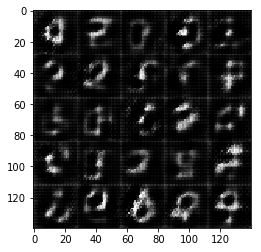

Epoch 1/2:  Discriminator loss = 1.3506  Generator loss = 2.1239
Epoch 1/2:  Discriminator loss = 0.8200  Generator loss = 1.2177
Epoch 1/2:  Discriminator loss = 1.3145  Generator loss = 0.5391
Epoch 1/2:  Discriminator loss = 1.2967  Generator loss = 0.5500
Epoch 1/2:  Discriminator loss = 1.1852  Generator loss = 0.8314
Epoch 1/2:  Discriminator loss = 1.3363  Generator loss = 1.6198
Epoch 1/2:  Discriminator loss = 1.4045  Generator loss = 0.5784
Epoch 1/2:  Discriminator loss = 1.1872  Generator loss = 0.6059
Epoch 1/2:  Discriminator loss = 1.3548  Generator loss = 0.5943
Epoch 1/2:  Discriminator loss = 1.1893  Generator loss = 0.5411


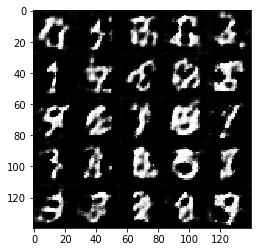

Epoch 1/2:  Discriminator loss = 2.7829  Generator loss = 0.0999
Epoch 1/2:  Discriminator loss = 0.7664  Generator loss = 1.1158
Epoch 1/2:  Discriminator loss = 0.9547  Generator loss = 0.7711
Epoch 1/2:  Discriminator loss = 0.6591  Generator loss = 1.5205
Epoch 1/2:  Discriminator loss = 1.1949  Generator loss = 1.7713
Epoch 1/2:  Discriminator loss = 0.8209  Generator loss = 1.0851
Epoch 1/2:  Discriminator loss = 0.9254  Generator loss = 1.8133
Epoch 1/2:  Discriminator loss = 1.2113  Generator loss = 1.1108
Epoch 1/2:  Discriminator loss = 1.2284  Generator loss = 0.6670
Epoch 1/2:  Discriminator loss = 1.3439  Generator loss = 0.5421


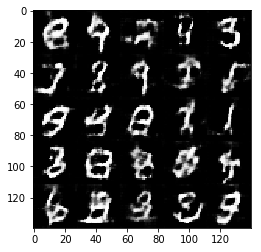

Epoch 1/2:  Discriminator loss = 1.2715  Generator loss = 1.3886
Epoch 1/2:  Discriminator loss = 1.1514  Generator loss = 0.9407
Epoch 1/2:  Discriminator loss = 1.1014  Generator loss = 1.4533
Epoch 1/2:  Discriminator loss = 1.3402  Generator loss = 1.6963
Epoch 1/2:  Discriminator loss = 1.3360  Generator loss = 2.0241
Epoch 1/2:  Discriminator loss = 0.8990  Generator loss = 1.0894
Epoch 1/2:  Discriminator loss = 1.5286  Generator loss = 2.3392
Epoch 1/2:  Discriminator loss = 0.9312  Generator loss = 0.9996
Epoch 1/2:  Discriminator loss = 1.1335  Generator loss = 0.7870
Epoch 1/2:  Discriminator loss = 1.0724  Generator loss = 1.3728


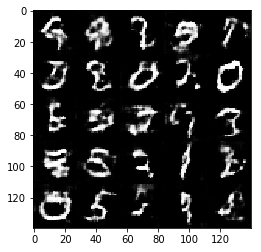

Epoch 1/2:  Discriminator loss = 1.2792  Generator loss = 2.2958
Epoch 1/2:  Discriminator loss = 1.2507  Generator loss = 0.5461
Epoch 1/2:  Discriminator loss = 1.0288  Generator loss = 1.1191
Epoch 1/2:  Discriminator loss = 0.9643  Generator loss = 0.8244
Epoch 1/2:  Discriminator loss = 1.0633  Generator loss = 1.3052
Epoch 1/2:  Discriminator loss = 1.1766  Generator loss = 0.5248
Epoch 2/2:  Discriminator loss = 1.1641  Generator loss = 0.7963
Epoch 2/2:  Discriminator loss = 1.1082  Generator loss = 0.6858
Epoch 2/2:  Discriminator loss = 1.0230  Generator loss = 1.5021
Epoch 2/2:  Discriminator loss = 1.3201  Generator loss = 0.4315
Epoch 2/2:  Discriminator loss = 1.6574  Generator loss = 0.2957
Epoch 2/2:  Discriminator loss = 1.1092  Generator loss = 0.6088
Epoch 2/2:  Discriminator loss = 1.3876  Generator loss = 0.5113
Epoch 2/2:  Discriminator loss = 0.9186  Generator loss = 1.2444
Epoch 2/2:  Discriminator loss = 1.1115  Generator loss = 1.7545
Epoch 2/2:  Discriminator

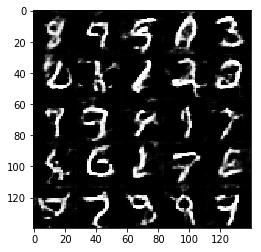

Epoch 2/2:  Discriminator loss = 1.0608  Generator loss = 0.9539
Epoch 2/2:  Discriminator loss = 0.9978  Generator loss = 0.9634
Epoch 2/2:  Discriminator loss = 1.3421  Generator loss = 1.5669
Epoch 2/2:  Discriminator loss = 1.2141  Generator loss = 0.5612
Epoch 2/2:  Discriminator loss = 1.0565  Generator loss = 0.6683
Epoch 2/2:  Discriminator loss = 1.0149  Generator loss = 0.8498
Epoch 2/2:  Discriminator loss = 1.0856  Generator loss = 0.7483
Epoch 2/2:  Discriminator loss = 1.3619  Generator loss = 0.4582
Epoch 2/2:  Discriminator loss = 0.8438  Generator loss = 1.2814
Epoch 2/2:  Discriminator loss = 1.3487  Generator loss = 2.2632


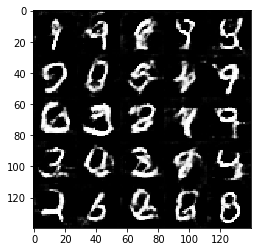

Epoch 2/2:  Discriminator loss = 1.2388  Generator loss = 0.5858
Epoch 2/2:  Discriminator loss = 0.8685  Generator loss = 0.9526
Epoch 2/2:  Discriminator loss = 1.1304  Generator loss = 0.7362
Epoch 2/2:  Discriminator loss = 0.8447  Generator loss = 1.2323
Epoch 2/2:  Discriminator loss = 0.9680  Generator loss = 1.6766
Epoch 2/2:  Discriminator loss = 0.8010  Generator loss = 1.6148
Epoch 2/2:  Discriminator loss = 0.8935  Generator loss = 1.1436
Epoch 2/2:  Discriminator loss = 0.9295  Generator loss = 0.7642
Epoch 2/2:  Discriminator loss = 0.8960  Generator loss = 1.2489
Epoch 2/2:  Discriminator loss = 1.5823  Generator loss = 0.4094


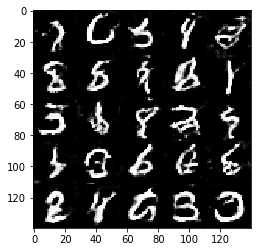

Epoch 2/2:  Discriminator loss = 0.8694  Generator loss = 0.7988
Epoch 2/2:  Discriminator loss = 1.5644  Generator loss = 0.4076
Epoch 2/2:  Discriminator loss = 0.8948  Generator loss = 1.1088
Epoch 2/2:  Discriminator loss = 1.1648  Generator loss = 0.7809
Epoch 2/2:  Discriminator loss = 0.9010  Generator loss = 1.5312
Epoch 2/2:  Discriminator loss = 0.8250  Generator loss = 1.4098
Epoch 2/2:  Discriminator loss = 0.9117  Generator loss = 1.7608
Epoch 2/2:  Discriminator loss = 0.9092  Generator loss = 1.1361
Epoch 2/2:  Discriminator loss = 1.0124  Generator loss = 1.4806
Epoch 2/2:  Discriminator loss = 0.9423  Generator loss = 2.1707


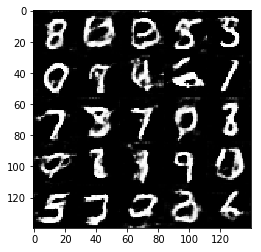

Epoch 2/2:  Discriminator loss = 0.7322  Generator loss = 1.2450
Epoch 2/2:  Discriminator loss = 0.8772  Generator loss = 0.7508
Epoch 2/2:  Discriminator loss = 1.0710  Generator loss = 2.0948
Epoch 2/2:  Discriminator loss = 0.9212  Generator loss = 1.4184
Epoch 2/2:  Discriminator loss = 1.0233  Generator loss = 1.0715
Epoch 2/2:  Discriminator loss = 0.9856  Generator loss = 0.9560


In [14]:
batch_size = 128
z_dim = 120
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1:  Discriminator loss = 0.0992  Generator loss = 8.0994
Epoch 1/1:  Discriminator loss = 3.5002  Generator loss = 0.5367
Epoch 1/1:  Discriminator loss = 3.9087  Generator loss = 0.0832
Epoch 1/1:  Discriminator loss = 3.3994  Generator loss = 5.7978
Epoch 1/1:  Discriminator loss = 0.5111  Generator loss = 1.4440
Epoch 1/1:  Discriminator loss = 2.1231  Generator loss = 4.7840
Epoch 1/1:  Discriminator loss = 0.8526  Generator loss = 0.8716
Epoch 1/1:  Discriminator loss = 1.5254  Generator loss = 0.3044
Epoch 1/1:  Discriminator loss = 1.1938  Generator loss = 0.5861
Epoch 1/1:  Discriminator loss = 2.6158  Generator loss = 8.9183


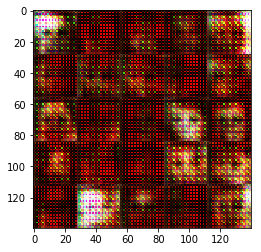

Epoch 1/1:  Discriminator loss = 0.2259  Generator loss = 2.5137
Epoch 1/1:  Discriminator loss = 1.1824  Generator loss = 0.7969
Epoch 1/1:  Discriminator loss = 0.2688  Generator loss = 2.1102
Epoch 1/1:  Discriminator loss = 0.4227  Generator loss = 1.3728
Epoch 1/1:  Discriminator loss = 0.1239  Generator loss = 2.5252
Epoch 1/1:  Discriminator loss = 3.1882  Generator loss = 0.0707
Epoch 1/1:  Discriminator loss = 0.9193  Generator loss = 1.1249
Epoch 1/1:  Discriminator loss = 1.8238  Generator loss = 3.1914
Epoch 1/1:  Discriminator loss = 4.1176  Generator loss = 5.5085
Epoch 1/1:  Discriminator loss = 0.1417  Generator loss = 2.4231


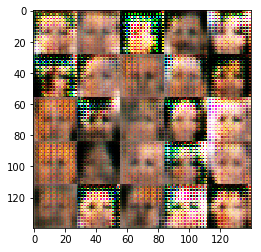

Epoch 1/1:  Discriminator loss = 2.9665  Generator loss = 0.4523
Epoch 1/1:  Discriminator loss = 0.7811  Generator loss = 1.0802
Epoch 1/1:  Discriminator loss = 2.3937  Generator loss = 0.1422
Epoch 1/1:  Discriminator loss = 1.2825  Generator loss = 0.7354
Epoch 1/1:  Discriminator loss = 1.8822  Generator loss = 0.3031
Epoch 1/1:  Discriminator loss = 1.2294  Generator loss = 0.8430
Epoch 1/1:  Discriminator loss = 1.1105  Generator loss = 0.9051
Epoch 1/1:  Discriminator loss = 1.1924  Generator loss = 0.6054
Epoch 1/1:  Discriminator loss = 0.8492  Generator loss = 0.7597
Epoch 1/1:  Discriminator loss = 0.9409  Generator loss = 0.8320


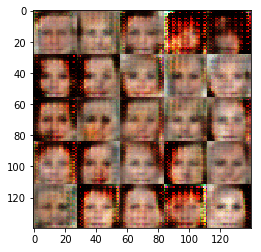

Epoch 1/1:  Discriminator loss = 1.4876  Generator loss = 3.1382
Epoch 1/1:  Discriminator loss = 1.1654  Generator loss = 1.0032
Epoch 1/1:  Discriminator loss = 1.1270  Generator loss = 0.6994
Epoch 1/1:  Discriminator loss = 0.5258  Generator loss = 1.6534
Epoch 1/1:  Discriminator loss = 0.8369  Generator loss = 2.1251
Epoch 1/1:  Discriminator loss = 1.7519  Generator loss = 0.4064
Epoch 1/1:  Discriminator loss = 1.2410  Generator loss = 1.9531
Epoch 1/1:  Discriminator loss = 1.2201  Generator loss = 0.9424
Epoch 1/1:  Discriminator loss = 2.3233  Generator loss = 0.8505
Epoch 1/1:  Discriminator loss = 0.8291  Generator loss = 0.9315


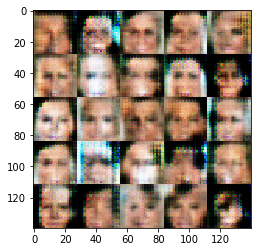

Epoch 1/1:  Discriminator loss = 1.2606  Generator loss = 0.7800
Epoch 1/1:  Discriminator loss = 0.9634  Generator loss = 0.8675
Epoch 1/1:  Discriminator loss = 0.8682  Generator loss = 0.7659
Epoch 1/1:  Discriminator loss = 1.3095  Generator loss = 0.4886
Epoch 1/1:  Discriminator loss = 1.0698  Generator loss = 0.6612
Epoch 1/1:  Discriminator loss = 1.2750  Generator loss = 0.4622
Epoch 1/1:  Discriminator loss = 2.2720  Generator loss = 0.2815
Epoch 1/1:  Discriminator loss = 0.7928  Generator loss = 0.8424
Epoch 1/1:  Discriminator loss = 1.5321  Generator loss = 0.5217
Epoch 1/1:  Discriminator loss = 1.4023  Generator loss = 0.5052


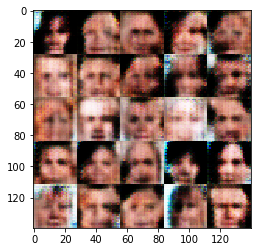

Epoch 1/1:  Discriminator loss = 1.3842  Generator loss = 1.4129
Epoch 1/1:  Discriminator loss = 1.4589  Generator loss = 2.2039
Epoch 1/1:  Discriminator loss = 1.6778  Generator loss = 1.6251
Epoch 1/1:  Discriminator loss = 1.0385  Generator loss = 0.7803
Epoch 1/1:  Discriminator loss = 1.0243  Generator loss = 2.0910
Epoch 1/1:  Discriminator loss = 1.5888  Generator loss = 0.4667
Epoch 1/1:  Discriminator loss = 1.0805  Generator loss = 0.7723
Epoch 1/1:  Discriminator loss = 0.9361  Generator loss = 1.1164
Epoch 1/1:  Discriminator loss = 1.1337  Generator loss = 0.7350
Epoch 1/1:  Discriminator loss = 1.1697  Generator loss = 1.0728


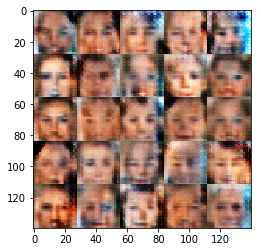

Epoch 1/1:  Discriminator loss = 0.9556  Generator loss = 0.6534
Epoch 1/1:  Discriminator loss = 0.8340  Generator loss = 1.8180
Epoch 1/1:  Discriminator loss = 0.9270  Generator loss = 0.8073
Epoch 1/1:  Discriminator loss = 1.1461  Generator loss = 0.8154
Epoch 1/1:  Discriminator loss = 2.1681  Generator loss = 0.1508
Epoch 1/1:  Discriminator loss = 0.9472  Generator loss = 0.8160
Epoch 1/1:  Discriminator loss = 1.5519  Generator loss = 0.2628
Epoch 1/1:  Discriminator loss = 0.9687  Generator loss = 0.8919
Epoch 1/1:  Discriminator loss = 0.3717  Generator loss = 3.3702
Epoch 1/1:  Discriminator loss = 0.6194  Generator loss = 2.7199


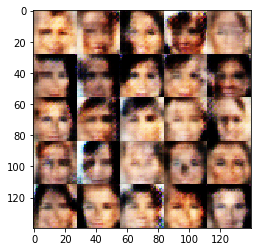

Epoch 1/1:  Discriminator loss = 1.0432  Generator loss = 0.8329
Epoch 1/1:  Discriminator loss = 0.9904  Generator loss = 4.0686
Epoch 1/1:  Discriminator loss = 0.7167  Generator loss = 0.7696
Epoch 1/1:  Discriminator loss = 0.1989  Generator loss = 2.4905
Epoch 1/1:  Discriminator loss = 0.4493  Generator loss = 2.4783
Epoch 1/1:  Discriminator loss = 0.9827  Generator loss = 0.7781
Epoch 1/1:  Discriminator loss = 0.2213  Generator loss = 3.9658
Epoch 1/1:  Discriminator loss = 0.1615  Generator loss = 2.2848
Epoch 1/1:  Discriminator loss = 0.6919  Generator loss = 0.9377
Epoch 1/1:  Discriminator loss = 1.3348  Generator loss = 1.3102


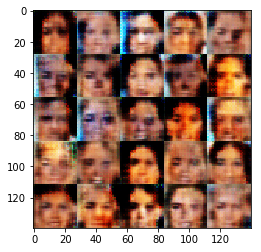

Epoch 1/1:  Discriminator loss = 0.8246  Generator loss = 1.0232
Epoch 1/1:  Discriminator loss = 2.6234  Generator loss = 0.1235
Epoch 1/1:  Discriminator loss = 0.7824  Generator loss = 0.8446
Epoch 1/1:  Discriminator loss = 0.2466  Generator loss = 2.1674
Epoch 1/1:  Discriminator loss = 0.0321  Generator loss = 5.9178
Epoch 1/1:  Discriminator loss = 0.0825  Generator loss = 3.5597
Epoch 1/1:  Discriminator loss = 0.0102  Generator loss = 5.7885
Epoch 1/1:  Discriminator loss = 0.5526  Generator loss = 1.0100
Epoch 1/1:  Discriminator loss = 0.0158  Generator loss = 5.7122
Epoch 1/1:  Discriminator loss = 0.0877  Generator loss = 2.7416


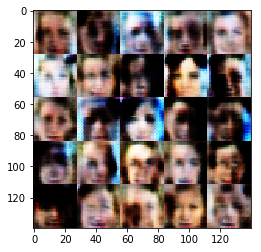

Epoch 1/1:  Discriminator loss = 0.8690  Generator loss = 8.3175
Epoch 1/1:  Discriminator loss = 1.1501  Generator loss = 1.2937
Epoch 1/1:  Discriminator loss = 1.2796  Generator loss = 2.2673
Epoch 1/1:  Discriminator loss = 1.3943  Generator loss = 0.4032
Epoch 1/1:  Discriminator loss = 1.3101  Generator loss = 0.5339
Epoch 1/1:  Discriminator loss = 1.2672  Generator loss = 0.8476
Epoch 1/1:  Discriminator loss = 1.2830  Generator loss = 0.5559
Epoch 1/1:  Discriminator loss = 1.0700  Generator loss = 0.7086
Epoch 1/1:  Discriminator loss = 1.2909  Generator loss = 0.8702
Epoch 1/1:  Discriminator loss = 1.1294  Generator loss = 0.7328


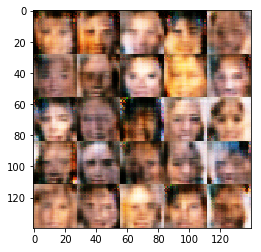

Epoch 1/1:  Discriminator loss = 1.0040  Generator loss = 0.9403
Epoch 1/1:  Discriminator loss = 1.3439  Generator loss = 0.4945
Epoch 1/1:  Discriminator loss = 1.1588  Generator loss = 0.8134
Epoch 1/1:  Discriminator loss = 1.4517  Generator loss = 0.4044
Epoch 1/1:  Discriminator loss = 0.9433  Generator loss = 1.0985
Epoch 1/1:  Discriminator loss = 1.1023  Generator loss = 0.8307
Epoch 1/1:  Discriminator loss = 1.0808  Generator loss = 1.0857
Epoch 1/1:  Discriminator loss = 1.1067  Generator loss = 1.2377
Epoch 1/1:  Discriminator loss = 1.3132  Generator loss = 0.6865
Epoch 1/1:  Discriminator loss = 1.1838  Generator loss = 0.8641


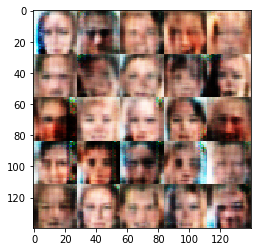

Epoch 1/1:  Discriminator loss = 1.0571  Generator loss = 0.7442
Epoch 1/1:  Discriminator loss = 1.1110  Generator loss = 0.8696
Epoch 1/1:  Discriminator loss = 1.4225  Generator loss = 0.6138
Epoch 1/1:  Discriminator loss = 1.1705  Generator loss = 0.6597
Epoch 1/1:  Discriminator loss = 1.0027  Generator loss = 0.8579
Epoch 1/1:  Discriminator loss = 1.4271  Generator loss = 0.4559
Epoch 1/1:  Discriminator loss = 0.9191  Generator loss = 1.1900
Epoch 1/1:  Discriminator loss = 1.3111  Generator loss = 0.7594
Epoch 1/1:  Discriminator loss = 1.1398  Generator loss = 0.8737
Epoch 1/1:  Discriminator loss = 1.4401  Generator loss = 0.5884


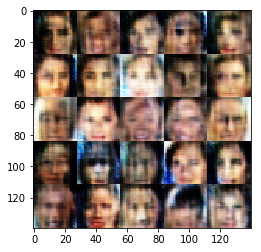

Epoch 1/1:  Discriminator loss = 1.3820  Generator loss = 0.7223
Epoch 1/1:  Discriminator loss = 0.9848  Generator loss = 0.7982
Epoch 1/1:  Discriminator loss = 1.1548  Generator loss = 1.0385
Epoch 1/1:  Discriminator loss = 1.1544  Generator loss = 0.6699
Epoch 1/1:  Discriminator loss = 0.9652  Generator loss = 1.1164
Epoch 1/1:  Discriminator loss = 1.4014  Generator loss = 0.3989
Epoch 1/1:  Discriminator loss = 1.2518  Generator loss = 0.6023
Epoch 1/1:  Discriminator loss = 0.9264  Generator loss = 0.9100
Epoch 1/1:  Discriminator loss = 1.5762  Generator loss = 0.6724
Epoch 1/1:  Discriminator loss = 1.4194  Generator loss = 0.9040


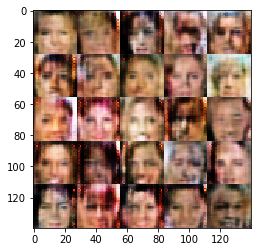

Epoch 1/1:  Discriminator loss = 1.1791  Generator loss = 0.6847
Epoch 1/1:  Discriminator loss = 1.3174  Generator loss = 0.5000
Epoch 1/1:  Discriminator loss = 1.2846  Generator loss = 0.9376
Epoch 1/1:  Discriminator loss = 1.2428  Generator loss = 0.6607
Epoch 1/1:  Discriminator loss = 1.2137  Generator loss = 0.7139
Epoch 1/1:  Discriminator loss = 1.0935  Generator loss = 0.9610
Epoch 1/1:  Discriminator loss = 1.2921  Generator loss = 0.5528
Epoch 1/1:  Discriminator loss = 1.1104  Generator loss = 1.0225
Epoch 1/1:  Discriminator loss = 1.2630  Generator loss = 0.8858
Epoch 1/1:  Discriminator loss = 1.2384  Generator loss = 0.7514


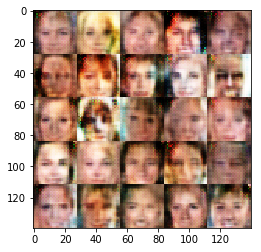

Epoch 1/1:  Discriminator loss = 1.2949  Generator loss = 0.4408
Epoch 1/1:  Discriminator loss = 1.5458  Generator loss = 0.8024
Epoch 1/1:  Discriminator loss = 1.2427  Generator loss = 0.6546
Epoch 1/1:  Discriminator loss = 1.2401  Generator loss = 0.8332
Epoch 1/1:  Discriminator loss = 0.9644  Generator loss = 0.9567
Epoch 1/1:  Discriminator loss = 0.8706  Generator loss = 0.8819
Epoch 1/1:  Discriminator loss = 0.8517  Generator loss = 1.1773
Epoch 1/1:  Discriminator loss = 1.0921  Generator loss = 0.9446
Epoch 1/1:  Discriminator loss = 0.4073  Generator loss = 2.0614
Epoch 1/1:  Discriminator loss = 0.9498  Generator loss = 1.0400


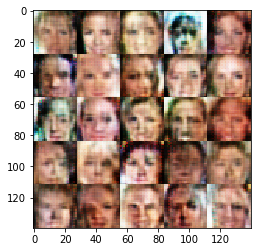

Epoch 1/1:  Discriminator loss = 0.9885  Generator loss = 0.8710
Epoch 1/1:  Discriminator loss = 1.1651  Generator loss = 0.8242
Epoch 1/1:  Discriminator loss = 1.2268  Generator loss = 1.4059
Epoch 1/1:  Discriminator loss = 1.3233  Generator loss = 0.6699
Epoch 1/1:  Discriminator loss = 1.4745  Generator loss = 0.6996
Epoch 1/1:  Discriminator loss = 1.3089  Generator loss = 0.6446
Epoch 1/1:  Discriminator loss = 1.1479  Generator loss = 0.9036
Epoch 1/1:  Discriminator loss = 1.3407  Generator loss = 0.5770
Epoch 1/1:  Discriminator loss = 1.1247  Generator loss = 0.6642
Epoch 1/1:  Discriminator loss = 1.2447  Generator loss = 0.6137


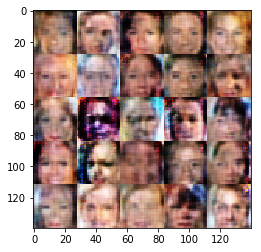

Epoch 1/1:  Discriminator loss = 1.2242  Generator loss = 0.4877
Epoch 1/1:  Discriminator loss = 1.1858  Generator loss = 0.9989
Epoch 1/1:  Discriminator loss = 1.4083  Generator loss = 0.4223
Epoch 1/1:  Discriminator loss = 0.8188  Generator loss = 0.9572
Epoch 1/1:  Discriminator loss = 1.1167  Generator loss = 0.8593
Epoch 1/1:  Discriminator loss = 1.2736  Generator loss = 0.9641
Epoch 1/1:  Discriminator loss = 1.1429  Generator loss = 0.7867
Epoch 1/1:  Discriminator loss = 1.5267  Generator loss = 1.0457
Epoch 1/1:  Discriminator loss = 1.3750  Generator loss = 0.7419
Epoch 1/1:  Discriminator loss = 1.5920  Generator loss = 1.2988


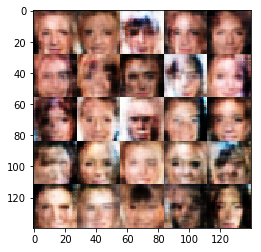

Epoch 1/1:  Discriminator loss = 1.0177  Generator loss = 0.6751
Epoch 1/1:  Discriminator loss = 0.5569  Generator loss = 1.1758
Epoch 1/1:  Discriminator loss = 2.3558  Generator loss = 0.2406
Epoch 1/1:  Discriminator loss = 0.2798  Generator loss = 2.5681
Epoch 1/1:  Discriminator loss = 1.3897  Generator loss = 0.5188
Epoch 1/1:  Discriminator loss = 1.0667  Generator loss = 0.9429
Epoch 1/1:  Discriminator loss = 1.2202  Generator loss = 0.7356
Epoch 1/1:  Discriminator loss = 1.2462  Generator loss = 0.5773
Epoch 1/1:  Discriminator loss = 1.1525  Generator loss = 0.7280
Epoch 1/1:  Discriminator loss = 1.4926  Generator loss = 0.6336


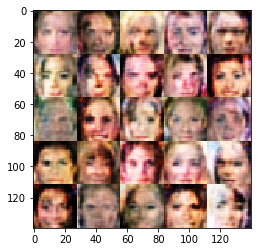

Epoch 1/1:  Discriminator loss = 1.1989  Generator loss = 0.9874
Epoch 1/1:  Discriminator loss = 1.2729  Generator loss = 0.8112
Epoch 1/1:  Discriminator loss = 1.2557  Generator loss = 0.9946
Epoch 1/1:  Discriminator loss = 1.2607  Generator loss = 0.7985
Epoch 1/1:  Discriminator loss = 1.4055  Generator loss = 0.7300
Epoch 1/1:  Discriminator loss = 1.3481  Generator loss = 1.3543
Epoch 1/1:  Discriminator loss = 1.3924  Generator loss = 1.0355
Epoch 1/1:  Discriminator loss = 1.2313  Generator loss = 1.5600
Epoch 1/1:  Discriminator loss = 1.2393  Generator loss = 1.1165
Epoch 1/1:  Discriminator loss = 1.2398  Generator loss = 0.9558


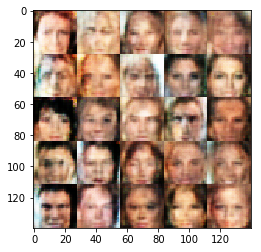

Epoch 1/1:  Discriminator loss = 1.1327  Generator loss = 0.9713
Epoch 1/1:  Discriminator loss = 1.2089  Generator loss = 0.9054
Epoch 1/1:  Discriminator loss = 1.1440  Generator loss = 0.9434
Epoch 1/1:  Discriminator loss = 1.1052  Generator loss = 0.6405
Epoch 1/1:  Discriminator loss = 1.2247  Generator loss = 1.5375
Epoch 1/1:  Discriminator loss = 2.0395  Generator loss = 0.5702
Epoch 1/1:  Discriminator loss = 1.3524  Generator loss = 0.5028
Epoch 1/1:  Discriminator loss = 2.0609  Generator loss = 2.2129
Epoch 1/1:  Discriminator loss = 1.9712  Generator loss = 0.2246
Epoch 1/1:  Discriminator loss = 0.8299  Generator loss = 0.8630


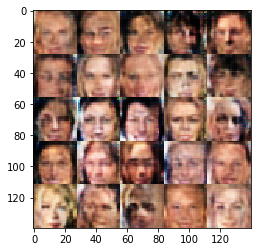

Epoch 1/1:  Discriminator loss = 1.0292  Generator loss = 0.5704
Epoch 1/1:  Discriminator loss = 1.0416  Generator loss = 0.9902
Epoch 1/1:  Discriminator loss = 1.7671  Generator loss = 0.2462
Epoch 1/1:  Discriminator loss = 0.9891  Generator loss = 1.7713
Epoch 1/1:  Discriminator loss = 1.6762  Generator loss = 1.0104
Epoch 1/1:  Discriminator loss = 0.9486  Generator loss = 0.8430
Epoch 1/1:  Discriminator loss = 1.4036  Generator loss = 0.8226
Epoch 1/1:  Discriminator loss = 1.3098  Generator loss = 0.7061
Epoch 1/1:  Discriminator loss = 1.1281  Generator loss = 0.7853
Epoch 1/1:  Discriminator loss = 1.1296  Generator loss = 0.6939


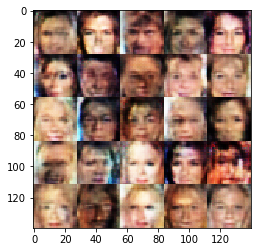

Epoch 1/1:  Discriminator loss = 1.1006  Generator loss = 0.7991
Epoch 1/1:  Discriminator loss = 1.3810  Generator loss = 1.1384
Epoch 1/1:  Discriminator loss = 1.0198  Generator loss = 2.5321
Epoch 1/1:  Discriminator loss = 1.7171  Generator loss = 0.9229
Epoch 1/1:  Discriminator loss = 1.9678  Generator loss = 1.7252
Epoch 1/1:  Discriminator loss = 0.5508  Generator loss = 1.4570
Epoch 1/1:  Discriminator loss = 1.4032  Generator loss = 2.8154
Epoch 1/1:  Discriminator loss = 1.3580  Generator loss = 0.3937
Epoch 1/1:  Discriminator loss = 1.1490  Generator loss = 0.6448
Epoch 1/1:  Discriminator loss = 1.6456  Generator loss = 0.7840


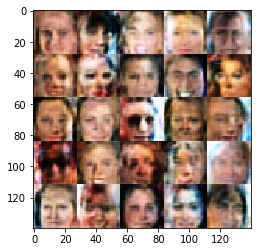

Epoch 1/1:  Discriminator loss = 1.1087  Generator loss = 0.8786
Epoch 1/1:  Discriminator loss = 0.9707  Generator loss = 0.7473
Epoch 1/1:  Discriminator loss = 1.6378  Generator loss = 1.8331
Epoch 1/1:  Discriminator loss = 1.2245  Generator loss = 0.5496
Epoch 1/1:  Discriminator loss = 1.2853  Generator loss = 0.4844
Epoch 1/1:  Discriminator loss = 0.4026  Generator loss = 2.1587
Epoch 1/1:  Discriminator loss = 0.3141  Generator loss = 2.3287
Epoch 1/1:  Discriminator loss = 3.7046  Generator loss = 0.0318
Epoch 1/1:  Discriminator loss = 2.4963  Generator loss = 0.1946
Epoch 1/1:  Discriminator loss = 1.2669  Generator loss = 0.4401


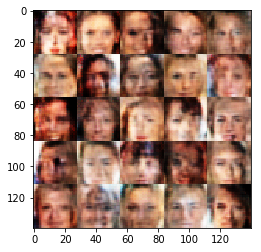

Epoch 1/1:  Discriminator loss = 1.2905  Generator loss = 0.7655
Epoch 1/1:  Discriminator loss = 1.4436  Generator loss = 2.6667
Epoch 1/1:  Discriminator loss = 0.1502  Generator loss = 2.5565
Epoch 1/1:  Discriminator loss = 1.9155  Generator loss = 0.2358
Epoch 1/1:  Discriminator loss = 1.2996  Generator loss = 0.4186
Epoch 1/1:  Discriminator loss = 0.8556  Generator loss = 2.5830
Epoch 1/1:  Discriminator loss = 0.2318  Generator loss = 2.3191
Epoch 1/1:  Discriminator loss = 0.8459  Generator loss = 0.8280
Epoch 1/1:  Discriminator loss = 0.7182  Generator loss = 1.3730
Epoch 1/1:  Discriminator loss = 0.9616  Generator loss = 0.6354


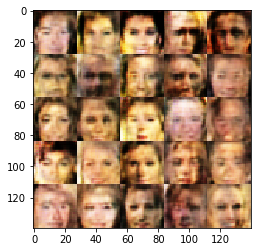

Epoch 1/1:  Discriminator loss = 0.5773  Generator loss = 1.0520
Epoch 1/1:  Discriminator loss = 0.9062  Generator loss = 1.4285
Epoch 1/1:  Discriminator loss = 0.9282  Generator loss = 1.1531
Epoch 1/1:  Discriminator loss = 1.1951  Generator loss = 0.8550
Epoch 1/1:  Discriminator loss = 1.0955  Generator loss = 1.0182
Epoch 1/1:  Discriminator loss = 1.3352  Generator loss = 0.6810
Epoch 1/1:  Discriminator loss = 1.2198  Generator loss = 0.7379
Epoch 1/1:  Discriminator loss = 1.9107  Generator loss = 0.1924
Epoch 1/1:  Discriminator loss = 1.0877  Generator loss = 0.6146
Epoch 1/1:  Discriminator loss = 1.2388  Generator loss = 1.1162


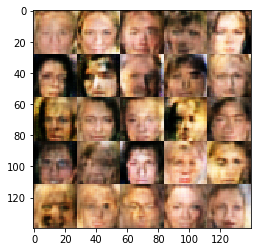

Epoch 1/1:  Discriminator loss = 1.4566  Generator loss = 0.5972
Epoch 1/1:  Discriminator loss = 0.6334  Generator loss = 1.0338
Epoch 1/1:  Discriminator loss = 1.0914  Generator loss = 0.6495
Epoch 1/1:  Discriminator loss = 1.5829  Generator loss = 0.3664
Epoch 1/1:  Discriminator loss = 2.1810  Generator loss = 0.7809
Epoch 1/1:  Discriminator loss = 1.8613  Generator loss = 0.2712
Epoch 1/1:  Discriminator loss = 1.7708  Generator loss = 1.4002
Epoch 1/1:  Discriminator loss = 1.5169  Generator loss = 0.6337
Epoch 1/1:  Discriminator loss = 0.9417  Generator loss = 0.7215
Epoch 1/1:  Discriminator loss = 0.4632  Generator loss = 1.3506


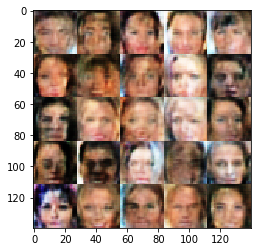

Epoch 1/1:  Discriminator loss = 0.6477  Generator loss = 1.8995
Epoch 1/1:  Discriminator loss = 0.2268  Generator loss = 2.1141
Epoch 1/1:  Discriminator loss = 0.9192  Generator loss = 1.2610
Epoch 1/1:  Discriminator loss = 1.0101  Generator loss = 0.7250
Epoch 1/1:  Discriminator loss = 1.8679  Generator loss = 0.2387
Epoch 1/1:  Discriminator loss = 1.0803  Generator loss = 0.6531
Epoch 1/1:  Discriminator loss = 2.2463  Generator loss = 0.1495
Epoch 1/1:  Discriminator loss = 0.6042  Generator loss = 1.7344
Epoch 1/1:  Discriminator loss = 1.5303  Generator loss = 0.3869
Epoch 1/1:  Discriminator loss = 0.8399  Generator loss = 1.4390


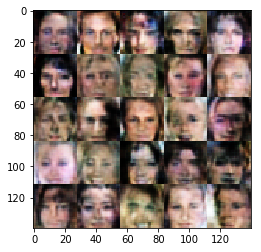

Epoch 1/1:  Discriminator loss = 0.8934  Generator loss = 1.7776
Epoch 1/1:  Discriminator loss = 0.2971  Generator loss = 4.5833
Epoch 1/1:  Discriminator loss = 1.1140  Generator loss = 0.5897
Epoch 1/1:  Discriminator loss = 0.9456  Generator loss = 0.7087
Epoch 1/1:  Discriminator loss = 0.9728  Generator loss = 1.5297
Epoch 1/1:  Discriminator loss = 2.2177  Generator loss = 0.1422
Epoch 1/1:  Discriminator loss = 0.9954  Generator loss = 1.3309
Epoch 1/1:  Discriminator loss = 2.0479  Generator loss = 0.2238
Epoch 1/1:  Discriminator loss = 0.7385  Generator loss = 0.8750
Epoch 1/1:  Discriminator loss = 1.1021  Generator loss = 0.6660


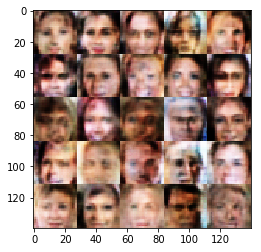

Epoch 1/1:  Discriminator loss = 1.0532  Generator loss = 0.5859
Epoch 1/1:  Discriminator loss = 1.0461  Generator loss = 0.9090
Epoch 1/1:  Discriminator loss = 0.2049  Generator loss = 2.3175
Epoch 1/1:  Discriminator loss = 0.7985  Generator loss = 1.2696
Epoch 1/1:  Discriminator loss = 0.9419  Generator loss = 2.1056
Epoch 1/1:  Discriminator loss = 1.0907  Generator loss = 0.8973
Epoch 1/1:  Discriminator loss = 1.2487  Generator loss = 1.1242
Epoch 1/1:  Discriminator loss = 1.2940  Generator loss = 1.0995
Epoch 1/1:  Discriminator loss = 1.1383  Generator loss = 1.1427
Epoch 1/1:  Discriminator loss = 1.0303  Generator loss = 0.7687


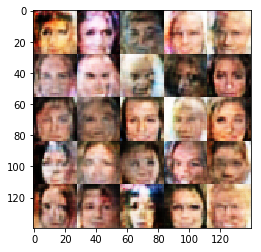

Epoch 1/1:  Discriminator loss = 1.1351  Generator loss = 0.7594
Epoch 1/1:  Discriminator loss = 1.1463  Generator loss = 0.6774
Epoch 1/1:  Discriminator loss = 1.0264  Generator loss = 0.8858
Epoch 1/1:  Discriminator loss = 1.2538  Generator loss = 0.8298
Epoch 1/1:  Discriminator loss = 1.0716  Generator loss = 0.9472
Epoch 1/1:  Discriminator loss = 1.2895  Generator loss = 1.1818
Epoch 1/1:  Discriminator loss = 1.0475  Generator loss = 0.9175
Epoch 1/1:  Discriminator loss = 1.1033  Generator loss = 0.9415
Epoch 1/1:  Discriminator loss = 0.7052  Generator loss = 1.1803
Epoch 1/1:  Discriminator loss = 0.6034  Generator loss = 1.3972


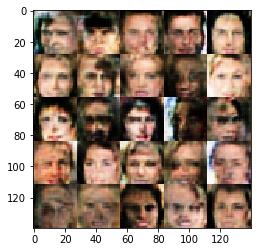

Epoch 1/1:  Discriminator loss = 0.8876  Generator loss = 3.2792
Epoch 1/1:  Discriminator loss = 0.8538  Generator loss = 1.3203
Epoch 1/1:  Discriminator loss = 1.2415  Generator loss = 0.6506
Epoch 1/1:  Discriminator loss = 0.9604  Generator loss = 0.8453
Epoch 1/1:  Discriminator loss = 0.9807  Generator loss = 0.7705
Epoch 1/1:  Discriminator loss = 1.2256  Generator loss = 1.1646
Epoch 1/1:  Discriminator loss = 1.1964  Generator loss = 0.7482
Epoch 1/1:  Discriminator loss = 1.0988  Generator loss = 0.6391
Epoch 1/1:  Discriminator loss = 1.3719  Generator loss = 0.4259
Epoch 1/1:  Discriminator loss = 1.2945  Generator loss = 0.5171


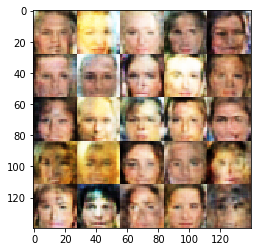

Epoch 1/1:  Discriminator loss = 1.2673  Generator loss = 0.5958
Epoch 1/1:  Discriminator loss = 1.1706  Generator loss = 0.6673
Epoch 1/1:  Discriminator loss = 0.5325  Generator loss = 2.0769
Epoch 1/1:  Discriminator loss = 1.2166  Generator loss = 1.0689
Epoch 1/1:  Discriminator loss = 1.2090  Generator loss = 0.7635
Epoch 1/1:  Discriminator loss = 1.1884  Generator loss = 0.7715
Epoch 1/1:  Discriminator loss = 1.4613  Generator loss = 2.0891
Epoch 1/1:  Discriminator loss = 1.0640  Generator loss = 0.8123
Epoch 1/1:  Discriminator loss = 1.3950  Generator loss = 0.4959
Epoch 1/1:  Discriminator loss = 1.1853  Generator loss = 0.6168


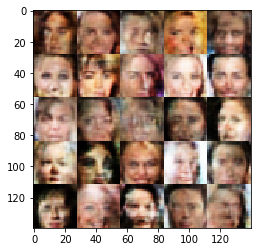

Epoch 1/1:  Discriminator loss = 0.8890  Generator loss = 2.0256
Epoch 1/1:  Discriminator loss = 0.4526  Generator loss = 1.9047
Epoch 1/1:  Discriminator loss = 0.9961  Generator loss = 0.8189
Epoch 1/1:  Discriminator loss = 0.8751  Generator loss = 2.4919
Epoch 1/1:  Discriminator loss = 1.4651  Generator loss = 0.4164
Epoch 1/1:  Discriminator loss = 0.7716  Generator loss = 0.7819
Epoch 1/1:  Discriminator loss = 1.9937  Generator loss = 0.1661
Epoch 1/1:  Discriminator loss = 1.0085  Generator loss = 0.7853
Epoch 1/1:  Discriminator loss = 1.1835  Generator loss = 0.6976
Epoch 1/1:  Discriminator loss = 1.0184  Generator loss = 1.1396


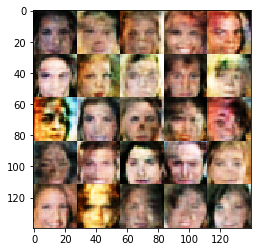

Epoch 1/1:  Discriminator loss = 0.9556  Generator loss = 1.0720
Epoch 1/1:  Discriminator loss = 0.9340  Generator loss = 0.8608
Epoch 1/1:  Discriminator loss = 1.1306  Generator loss = 0.6846
Epoch 1/1:  Discriminator loss = 0.7944  Generator loss = 1.4019
Epoch 1/1:  Discriminator loss = 1.0191  Generator loss = 0.9196
Epoch 1/1:  Discriminator loss = 1.2899  Generator loss = 0.4172
Epoch 1/1:  Discriminator loss = 1.6408  Generator loss = 0.3016
Epoch 1/1:  Discriminator loss = 0.1940  Generator loss = 2.6813
Epoch 1/1:  Discriminator loss = 1.7157  Generator loss = 0.3354
Epoch 1/1:  Discriminator loss = 1.7049  Generator loss = 0.2604


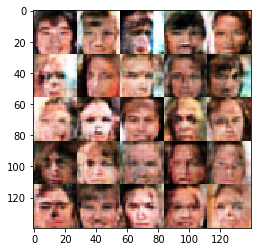

Epoch 1/1:  Discriminator loss = 1.0879  Generator loss = 0.6818
Epoch 1/1:  Discriminator loss = 0.9427  Generator loss = 0.7177
Epoch 1/1:  Discriminator loss = 1.5624  Generator loss = 0.6417
Epoch 1/1:  Discriminator loss = 0.3986  Generator loss = 1.7756
Epoch 1/1:  Discriminator loss = 1.4505  Generator loss = 0.3541
Epoch 1/1:  Discriminator loss = 0.5121  Generator loss = 1.7063
Epoch 1/1:  Discriminator loss = 0.8662  Generator loss = 0.9198
Epoch 1/1:  Discriminator loss = 1.1082  Generator loss = 3.0212
Epoch 1/1:  Discriminator loss = 0.7576  Generator loss = 2.6872
Epoch 1/1:  Discriminator loss = 0.9590  Generator loss = 0.8124


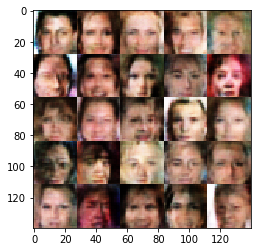

Epoch 1/1:  Discriminator loss = 0.3021  Generator loss = 2.0332
Epoch 1/1:  Discriminator loss = 0.2643  Generator loss = 1.9267
Epoch 1/1:  Discriminator loss = 0.7488  Generator loss = 1.8642
Epoch 1/1:  Discriminator loss = 0.7101  Generator loss = 3.0089
Epoch 1/1:  Discriminator loss = 0.2717  Generator loss = 2.9081
Epoch 1/1:  Discriminator loss = 0.4411  Generator loss = 1.8293
Epoch 1/1:  Discriminator loss = 0.6686  Generator loss = 1.3484
Epoch 1/1:  Discriminator loss = 0.5738  Generator loss = 2.3387
Epoch 1/1:  Discriminator loss = 0.5308  Generator loss = 1.8626
Epoch 1/1:  Discriminator loss = 1.2834  Generator loss = 0.4328


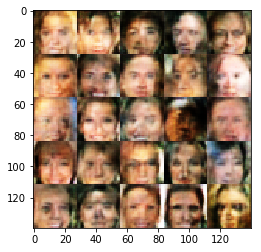

Epoch 1/1:  Discriminator loss = 1.1229  Generator loss = 0.6071
Epoch 1/1:  Discriminator loss = 1.2902  Generator loss = 0.6612
Epoch 1/1:  Discriminator loss = 0.5696  Generator loss = 1.4914
Epoch 1/1:  Discriminator loss = 1.7278  Generator loss = 2.3379
Epoch 1/1:  Discriminator loss = 2.2229  Generator loss = 0.1483
Epoch 1/1:  Discriminator loss = 1.6113  Generator loss = 0.3803
Epoch 1/1:  Discriminator loss = 0.7139  Generator loss = 0.9397
Epoch 1/1:  Discriminator loss = 0.4615  Generator loss = 1.5248
Epoch 1/1:  Discriminator loss = 1.1315  Generator loss = 0.7218
Epoch 1/1:  Discriminator loss = 0.3569  Generator loss = 1.5291


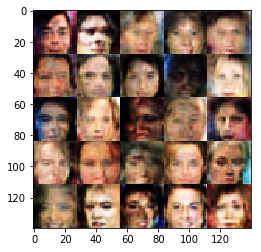

Epoch 1/1:  Discriminator loss = 0.2690  Generator loss = 1.7830
Epoch 1/1:  Discriminator loss = 1.7232  Generator loss = 1.6283
Epoch 1/1:  Discriminator loss = 1.0071  Generator loss = 0.6909
Epoch 1/1:  Discriminator loss = 1.1976  Generator loss = 2.0903
Epoch 1/1:  Discriminator loss = 1.2033  Generator loss = 0.5741
Epoch 1/1:  Discriminator loss = 1.0292  Generator loss = 1.1510
Epoch 1/1:  Discriminator loss = 1.0516  Generator loss = 0.8748
Epoch 1/1:  Discriminator loss = 0.8312  Generator loss = 1.3167
Epoch 1/1:  Discriminator loss = 1.2690  Generator loss = 0.9758
Epoch 1/1:  Discriminator loss = 0.9127  Generator loss = 0.8827


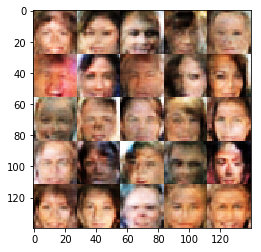

Epoch 1/1:  Discriminator loss = 0.7447  Generator loss = 1.4312
Epoch 1/1:  Discriminator loss = 0.5666  Generator loss = 1.0566
Epoch 1/1:  Discriminator loss = 0.4902  Generator loss = 4.4052
Epoch 1/1:  Discriminator loss = 0.8644  Generator loss = 0.9395
Epoch 1/1:  Discriminator loss = 0.9053  Generator loss = 1.0906
Epoch 1/1:  Discriminator loss = 0.7323  Generator loss = 1.2974
Epoch 1/1:  Discriminator loss = 1.0304  Generator loss = 0.8241
Epoch 1/1:  Discriminator loss = 1.1012  Generator loss = 1.2866
Epoch 1/1:  Discriminator loss = 0.8560  Generator loss = 0.8952
Epoch 1/1:  Discriminator loss = 2.3855  Generator loss = 1.6150


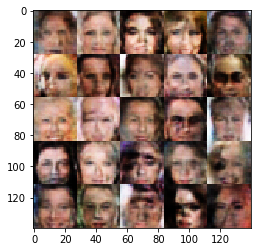

Epoch 1/1:  Discriminator loss = 1.1197  Generator loss = 0.9570
Epoch 1/1:  Discriminator loss = 0.8279  Generator loss = 0.7201
Epoch 1/1:  Discriminator loss = 0.6222  Generator loss = 1.4793
Epoch 1/1:  Discriminator loss = 1.1818  Generator loss = 0.4480
Epoch 1/1:  Discriminator loss = 1.0039  Generator loss = 1.3863
Epoch 1/1:  Discriminator loss = 0.4903  Generator loss = 2.1911
Epoch 1/1:  Discriminator loss = 1.4924  Generator loss = 1.0735
Epoch 1/1:  Discriminator loss = 0.9155  Generator loss = 1.1097
Epoch 1/1:  Discriminator loss = 0.8988  Generator loss = 0.8330
Epoch 1/1:  Discriminator loss = 1.1915  Generator loss = 0.5227


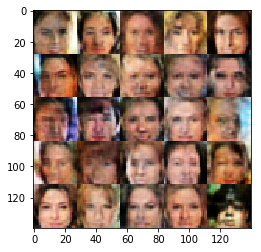

Epoch 1/1:  Discriminator loss = 1.1281  Generator loss = 0.8120
Epoch 1/1:  Discriminator loss = 1.1660  Generator loss = 0.9999
Epoch 1/1:  Discriminator loss = 1.1195  Generator loss = 0.7043
Epoch 1/1:  Discriminator loss = 1.0346  Generator loss = 0.9536
Epoch 1/1:  Discriminator loss = 0.8980  Generator loss = 0.8514
Epoch 1/1:  Discriminator loss = 1.1557  Generator loss = 1.2218
Epoch 1/1:  Discriminator loss = 1.7497  Generator loss = 0.3170
Epoch 1/1:  Discriminator loss = 0.8249  Generator loss = 1.4962
Epoch 1/1:  Discriminator loss = 0.9061  Generator loss = 0.8864
Epoch 1/1:  Discriminator loss = 1.0454  Generator loss = 0.7041


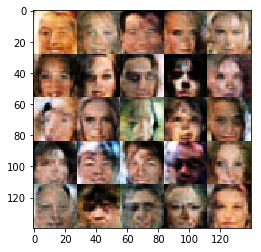

Epoch 1/1:  Discriminator loss = 0.9066  Generator loss = 1.6347
Epoch 1/1:  Discriminator loss = 1.0569  Generator loss = 0.7223
Epoch 1/1:  Discriminator loss = 1.1013  Generator loss = 1.1419
Epoch 1/1:  Discriminator loss = 1.2460  Generator loss = 0.9025
Epoch 1/1:  Discriminator loss = 1.0146  Generator loss = 1.0836
Epoch 1/1:  Discriminator loss = 0.8269  Generator loss = 1.3810
Epoch 1/1:  Discriminator loss = 0.4851  Generator loss = 1.6342
Epoch 1/1:  Discriminator loss = 1.9394  Generator loss = 0.2023
Epoch 1/1:  Discriminator loss = 1.0861  Generator loss = 0.6348
Epoch 1/1:  Discriminator loss = 0.8912  Generator loss = 0.6841


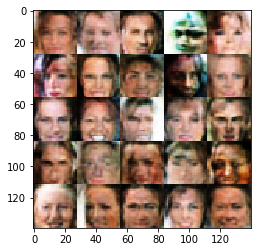

Epoch 1/1:  Discriminator loss = 0.2082  Generator loss = 2.4449
Epoch 1/1:  Discriminator loss = 1.0051  Generator loss = 0.6211
Epoch 1/1:  Discriminator loss = 2.4225  Generator loss = 0.1409
Epoch 1/1:  Discriminator loss = 1.2956  Generator loss = 0.4734
Epoch 1/1:  Discriminator loss = 0.7297  Generator loss = 1.8422
Epoch 1/1:  Discriminator loss = 1.0803  Generator loss = 0.5881
Epoch 1/1:  Discriminator loss = 0.7258  Generator loss = 1.1083
Epoch 1/1:  Discriminator loss = 1.0086  Generator loss = 0.8873
Epoch 1/1:  Discriminator loss = 1.0433  Generator loss = 0.6429
Epoch 1/1:  Discriminator loss = 0.8061  Generator loss = 1.3800


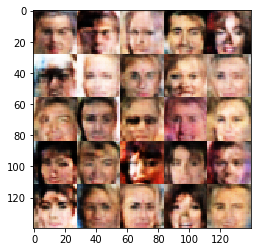

Epoch 1/1:  Discriminator loss = 0.3056  Generator loss = 1.8826
Epoch 1/1:  Discriminator loss = 1.6178  Generator loss = 0.3079
Epoch 1/1:  Discriminator loss = 1.4642  Generator loss = 1.4392
Epoch 1/1:  Discriminator loss = 1.3639  Generator loss = 0.4159
Epoch 1/1:  Discriminator loss = 1.1981  Generator loss = 0.5991
Epoch 1/1:  Discriminator loss = 1.1412  Generator loss = 0.5358
Epoch 1/1:  Discriminator loss = 1.1251  Generator loss = 1.6998
Epoch 1/1:  Discriminator loss = 0.5773  Generator loss = 1.0621
Epoch 1/1:  Discriminator loss = 0.8834  Generator loss = 0.7847
Epoch 1/1:  Discriminator loss = 0.4193  Generator loss = 2.4393


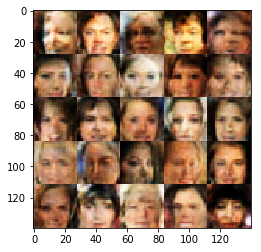

Epoch 1/1:  Discriminator loss = 1.4734  Generator loss = 0.3774
Epoch 1/1:  Discriminator loss = 1.9962  Generator loss = 2.7958
Epoch 1/1:  Discriminator loss = 0.1472  Generator loss = 2.4851
Epoch 1/1:  Discriminator loss = 0.3249  Generator loss = 1.6593
Epoch 1/1:  Discriminator loss = 1.8175  Generator loss = 0.2357
Epoch 1/1:  Discriminator loss = 0.8599  Generator loss = 1.2220
Epoch 1/1:  Discriminator loss = 1.5226  Generator loss = 0.3357
Epoch 1/1:  Discriminator loss = 0.5758  Generator loss = 1.4923
Epoch 1/1:  Discriminator loss = 1.1294  Generator loss = 0.6045
Epoch 1/1:  Discriminator loss = 0.1573  Generator loss = 3.0506


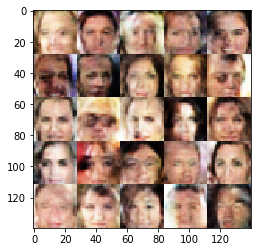

Epoch 1/1:  Discriminator loss = 1.0406  Generator loss = 1.5070
Epoch 1/1:  Discriminator loss = 1.2011  Generator loss = 0.8037
Epoch 1/1:  Discriminator loss = 0.9848  Generator loss = 0.7910
Epoch 1/1:  Discriminator loss = 0.7961  Generator loss = 1.2365
Epoch 1/1:  Discriminator loss = 0.8234  Generator loss = 1.4013
Epoch 1/1:  Discriminator loss = 1.9607  Generator loss = 0.2251
Epoch 1/1:  Discriminator loss = 0.2615  Generator loss = 3.7066
Epoch 1/1:  Discriminator loss = 0.5637  Generator loss = 1.1015
Epoch 1/1:  Discriminator loss = 0.1319  Generator loss = 4.7550
Epoch 1/1:  Discriminator loss = 0.9383  Generator loss = 0.7493


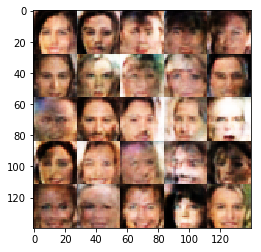

Epoch 1/1:  Discriminator loss = 1.1630  Generator loss = 0.6270
Epoch 1/1:  Discriminator loss = 0.9151  Generator loss = 0.9746
Epoch 1/1:  Discriminator loss = 1.3410  Generator loss = 0.3957
Epoch 1/1:  Discriminator loss = 1.9841  Generator loss = 0.2519
Epoch 1/1:  Discriminator loss = 1.7535  Generator loss = 0.2919
Epoch 1/1:  Discriminator loss = 0.2588  Generator loss = 2.3622
Epoch 1/1:  Discriminator loss = 0.1507  Generator loss = 2.8630
Epoch 1/1:  Discriminator loss = 0.4322  Generator loss = 3.3430
Epoch 1/1:  Discriminator loss = 0.7360  Generator loss = 2.3746
Epoch 1/1:  Discriminator loss = 0.3842  Generator loss = 1.5892


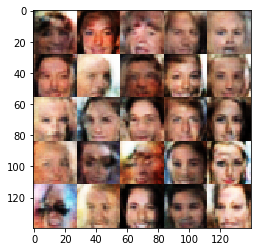

Epoch 1/1:  Discriminator loss = 1.7613  Generator loss = 0.2779
Epoch 1/1:  Discriminator loss = 0.5558  Generator loss = 1.8637
Epoch 1/1:  Discriminator loss = 0.5311  Generator loss = 1.2495
Epoch 1/1:  Discriminator loss = 1.2728  Generator loss = 0.5069
Epoch 1/1:  Discriminator loss = 0.4843  Generator loss = 2.6337
Epoch 1/1:  Discriminator loss = 1.2245  Generator loss = 0.6557
Epoch 1/1:  Discriminator loss = 1.1531  Generator loss = 0.9071
Epoch 1/1:  Discriminator loss = 0.5912  Generator loss = 1.4994
Epoch 1/1:  Discriminator loss = 0.6666  Generator loss = 0.9349
Epoch 1/1:  Discriminator loss = 1.2548  Generator loss = 0.5367


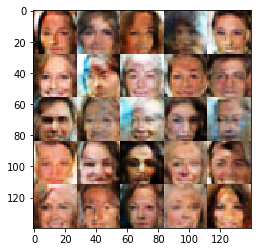

Epoch 1/1:  Discriminator loss = 1.6697  Generator loss = 1.9949
Epoch 1/1:  Discriminator loss = 0.4495  Generator loss = 1.3340
Epoch 1/1:  Discriminator loss = 1.3470  Generator loss = 0.4255
Epoch 1/1:  Discriminator loss = 0.8934  Generator loss = 0.9477
Epoch 1/1:  Discriminator loss = 0.8271  Generator loss = 1.1456
Epoch 1/1:  Discriminator loss = 1.3510  Generator loss = 0.4164
Epoch 1/1:  Discriminator loss = 1.0674  Generator loss = 0.8385
Epoch 1/1:  Discriminator loss = 0.7725  Generator loss = 1.1688
Epoch 1/1:  Discriminator loss = 0.6987  Generator loss = 1.6896
Epoch 1/1:  Discriminator loss = 1.7453  Generator loss = 0.2563


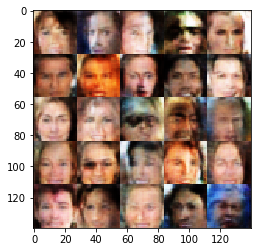

Epoch 1/1:  Discriminator loss = 0.7626  Generator loss = 1.6279
Epoch 1/1:  Discriminator loss = 0.8016  Generator loss = 0.8678
Epoch 1/1:  Discriminator loss = 0.4878  Generator loss = 1.4953
Epoch 1/1:  Discriminator loss = 1.2851  Generator loss = 0.6456
Epoch 1/1:  Discriminator loss = 0.3416  Generator loss = 3.7651
Epoch 1/1:  Discriminator loss = 1.2744  Generator loss = 0.4379
Epoch 1/1:  Discriminator loss = 0.4735  Generator loss = 2.0578
Epoch 1/1:  Discriminator loss = 0.8063  Generator loss = 1.2860
Epoch 1/1:  Discriminator loss = 0.4886  Generator loss = 1.5334
Epoch 1/1:  Discriminator loss = 0.4021  Generator loss = 2.0232


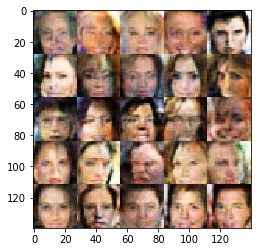

Epoch 1/1:  Discriminator loss = 0.8371  Generator loss = 1.6362
Epoch 1/1:  Discriminator loss = 1.3967  Generator loss = 1.0348
Epoch 1/1:  Discriminator loss = 0.5608  Generator loss = 1.2438
Epoch 1/1:  Discriminator loss = 0.7872  Generator loss = 1.0041
Epoch 1/1:  Discriminator loss = 0.8272  Generator loss = 1.0065
Epoch 1/1:  Discriminator loss = 1.9298  Generator loss = 4.9980
Epoch 1/1:  Discriminator loss = 1.3179  Generator loss = 0.4044
Epoch 1/1:  Discriminator loss = 1.0533  Generator loss = 0.6339
Epoch 1/1:  Discriminator loss = 1.0031  Generator loss = 1.1598
Epoch 1/1:  Discriminator loss = 0.6589  Generator loss = 2.8512


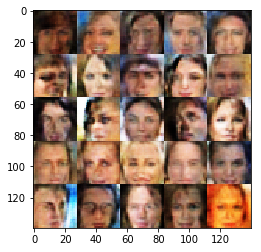

Epoch 1/1:  Discriminator loss = 0.4592  Generator loss = 2.9568
Epoch 1/1:  Discriminator loss = 1.2252  Generator loss = 3.1194
Epoch 1/1:  Discriminator loss = 0.8387  Generator loss = 0.8476
Epoch 1/1:  Discriminator loss = 0.9709  Generator loss = 0.6969
Epoch 1/1:  Discriminator loss = 0.1994  Generator loss = 3.3845
Epoch 1/1:  Discriminator loss = 1.7462  Generator loss = 0.3307
Epoch 1/1:  Discriminator loss = 0.7978  Generator loss = 1.1720
Epoch 1/1:  Discriminator loss = 0.9610  Generator loss = 0.7865
Epoch 1/1:  Discriminator loss = 1.6228  Generator loss = 0.3750
Epoch 1/1:  Discriminator loss = 0.2450  Generator loss = 2.1840


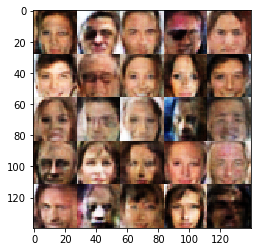

Epoch 1/1:  Discriminator loss = 0.6913  Generator loss = 1.2614
Epoch 1/1:  Discriminator loss = 0.7923  Generator loss = 1.3619
Epoch 1/1:  Discriminator loss = 1.2235  Generator loss = 0.5907
Epoch 1/1:  Discriminator loss = 0.9155  Generator loss = 0.9567
Epoch 1/1:  Discriminator loss = 0.9371  Generator loss = 1.0136
Epoch 1/1:  Discriminator loss = 0.7196  Generator loss = 1.0261
Epoch 1/1:  Discriminator loss = 0.4695  Generator loss = 2.0081
Epoch 1/1:  Discriminator loss = 1.4580  Generator loss = 0.3571
Epoch 1/1:  Discriminator loss = 1.0204  Generator loss = 0.8510
Epoch 1/1:  Discriminator loss = 1.1101  Generator loss = 0.6652


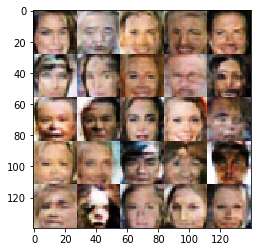

Epoch 1/1:  Discriminator loss = 1.0946  Generator loss = 0.7154
Epoch 1/1:  Discriminator loss = 0.9496  Generator loss = 0.7887
Epoch 1/1:  Discriminator loss = 0.6870  Generator loss = 1.0919
Epoch 1/1:  Discriminator loss = 0.3071  Generator loss = 2.4690
Epoch 1/1:  Discriminator loss = 0.8328  Generator loss = 0.7639
Epoch 1/1:  Discriminator loss = 0.5813  Generator loss = 1.3884
Epoch 1/1:  Discriminator loss = 0.5820  Generator loss = 1.1257
Epoch 1/1:  Discriminator loss = 1.0497  Generator loss = 1.1731
Epoch 1/1:  Discriminator loss = 0.8555  Generator loss = 1.9223
Epoch 1/1:  Discriminator loss = 0.5608  Generator loss = 1.3934


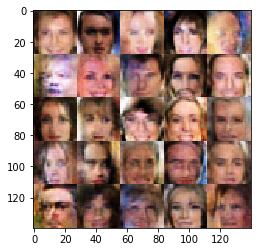

Epoch 1/1:  Discriminator loss = 1.0396  Generator loss = 0.7296
Epoch 1/1:  Discriminator loss = 0.8517  Generator loss = 1.1565
Epoch 1/1:  Discriminator loss = 1.3240  Generator loss = 0.4972
Epoch 1/1:  Discriminator loss = 0.9129  Generator loss = 1.0653
Epoch 1/1:  Discriminator loss = 0.9449  Generator loss = 0.7093
Epoch 1/1:  Discriminator loss = 0.8455  Generator loss = 0.8819
Epoch 1/1:  Discriminator loss = 0.2876  Generator loss = 1.6714
Epoch 1/1:  Discriminator loss = 1.1067  Generator loss = 0.8487
Epoch 1/1:  Discriminator loss = 1.6005  Generator loss = 0.3461
Epoch 1/1:  Discriminator loss = 0.8410  Generator loss = 1.3640


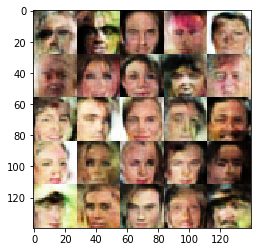

Epoch 1/1:  Discriminator loss = 1.4841  Generator loss = 0.3536
Epoch 1/1:  Discriminator loss = 1.4263  Generator loss = 0.5760
Epoch 1/1:  Discriminator loss = 1.0968  Generator loss = 0.6298
Epoch 1/1:  Discriminator loss = 1.1134  Generator loss = 2.3874
Epoch 1/1:  Discriminator loss = 0.9347  Generator loss = 0.9058
Epoch 1/1:  Discriminator loss = 0.5326  Generator loss = 1.4966
Epoch 1/1:  Discriminator loss = 0.4006  Generator loss = 1.8933
Epoch 1/1:  Discriminator loss = 1.3514  Generator loss = 0.4370
Epoch 1/1:  Discriminator loss = 1.3177  Generator loss = 0.5058
Epoch 1/1:  Discriminator loss = 1.4608  Generator loss = 0.6788


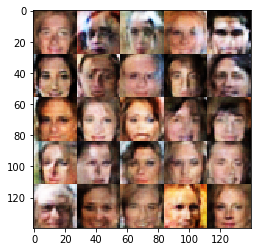

Epoch 1/1:  Discriminator loss = 0.8383  Generator loss = 1.4937
Epoch 1/1:  Discriminator loss = 0.7908  Generator loss = 1.0195
Epoch 1/1:  Discriminator loss = 0.7792  Generator loss = 1.2230
Epoch 1/1:  Discriminator loss = 0.3036  Generator loss = 3.8956
Epoch 1/1:  Discriminator loss = 0.6407  Generator loss = 1.1028
Epoch 1/1:  Discriminator loss = 0.2046  Generator loss = 4.2624
Epoch 1/1:  Discriminator loss = 0.0735  Generator loss = 3.4409
Epoch 1/1:  Discriminator loss = 1.0477  Generator loss = 0.5862
Epoch 1/1:  Discriminator loss = 1.3143  Generator loss = 0.4972
Epoch 1/1:  Discriminator loss = 0.8706  Generator loss = 0.9354


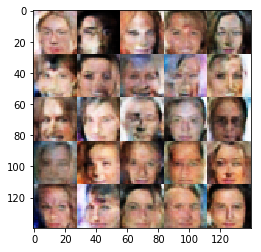

Epoch 1/1:  Discriminator loss = 0.7570  Generator loss = 0.9242
Epoch 1/1:  Discriminator loss = 0.3989  Generator loss = 1.5058
Epoch 1/1:  Discriminator loss = 1.0354  Generator loss = 2.8784
Epoch 1/1:  Discriminator loss = 1.2142  Generator loss = 0.5531
Epoch 1/1:  Discriminator loss = 0.9821  Generator loss = 0.7758
Epoch 1/1:  Discriminator loss = 2.0827  Generator loss = 0.1735
Epoch 1/1:  Discriminator loss = 0.7260  Generator loss = 1.2264
Epoch 1/1:  Discriminator loss = 1.6756  Generator loss = 2.2258
Epoch 1/1:  Discriminator loss = 0.1728  Generator loss = 2.8016
Epoch 1/1:  Discriminator loss = 2.5003  Generator loss = 0.1296


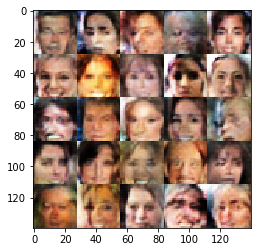

Epoch 1/1:  Discriminator loss = 0.2727  Generator loss = 2.1420
Epoch 1/1:  Discriminator loss = 1.0458  Generator loss = 0.8852
Epoch 1/1:  Discriminator loss = 1.6881  Generator loss = 0.3260
Epoch 1/1:  Discriminator loss = 0.4532  Generator loss = 1.9513
Epoch 1/1:  Discriminator loss = 0.6016  Generator loss = 0.9491
Epoch 1/1:  Discriminator loss = 0.7136  Generator loss = 1.1545
Epoch 1/1:  Discriminator loss = 1.0698  Generator loss = 0.8278
Epoch 1/1:  Discriminator loss = 1.0634  Generator loss = 0.6307
Epoch 1/1:  Discriminator loss = 0.5689  Generator loss = 1.3472
Epoch 1/1:  Discriminator loss = 1.0805  Generator loss = 1.4460


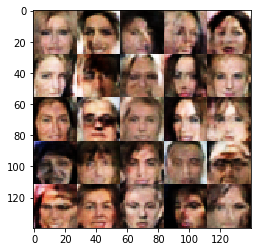

Epoch 1/1:  Discriminator loss = 0.9006  Generator loss = 2.4090
Epoch 1/1:  Discriminator loss = 0.1221  Generator loss = 3.3843
Epoch 1/1:  Discriminator loss = 1.0358  Generator loss = 2.3870
Epoch 1/1:  Discriminator loss = 0.0918  Generator loss = 5.4892
Epoch 1/1:  Discriminator loss = 0.6689  Generator loss = 1.1194
Epoch 1/1:  Discriminator loss = 2.9612  Generator loss = 4.8406
Epoch 1/1:  Discriminator loss = 0.4868  Generator loss = 2.6235
Epoch 1/1:  Discriminator loss = 1.3542  Generator loss = 0.3883
Epoch 1/1:  Discriminator loss = 2.3494  Generator loss = 0.1394
Epoch 1/1:  Discriminator loss = 1.3351  Generator loss = 0.9951


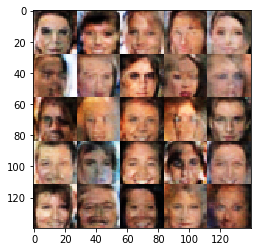

Epoch 1/1:  Discriminator loss = 0.2796  Generator loss = 2.5161
Epoch 1/1:  Discriminator loss = 0.8742  Generator loss = 2.0062
Epoch 1/1:  Discriminator loss = 0.8625  Generator loss = 0.7730
Epoch 1/1:  Discriminator loss = 0.7736  Generator loss = 1.0251
Epoch 1/1:  Discriminator loss = 0.7689  Generator loss = 1.0071
Epoch 1/1:  Discriminator loss = 2.4750  Generator loss = 0.1339
Epoch 1/1:  Discriminator loss = 0.8287  Generator loss = 1.0544
Epoch 1/1:  Discriminator loss = 0.7424  Generator loss = 1.2144
Epoch 1/1:  Discriminator loss = 1.2932  Generator loss = 0.4205
Epoch 1/1:  Discriminator loss = 1.3865  Generator loss = 0.4830


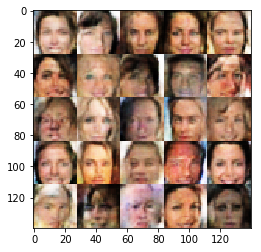

Epoch 1/1:  Discriminator loss = 1.0638  Generator loss = 0.6617
Epoch 1/1:  Discriminator loss = 0.9095  Generator loss = 0.6876
Epoch 1/1:  Discriminator loss = 0.7852  Generator loss = 1.0035
Epoch 1/1:  Discriminator loss = 0.5446  Generator loss = 1.1604
Epoch 1/1:  Discriminator loss = 1.0171  Generator loss = 1.9375
Epoch 1/1:  Discriminator loss = 0.5471  Generator loss = 1.3693
Epoch 1/1:  Discriminator loss = 0.6533  Generator loss = 1.3108
Epoch 1/1:  Discriminator loss = 0.6213  Generator loss = 1.2662
Epoch 1/1:  Discriminator loss = 0.2502  Generator loss = 2.8112
Epoch 1/1:  Discriminator loss = 0.1152  Generator loss = 3.2565


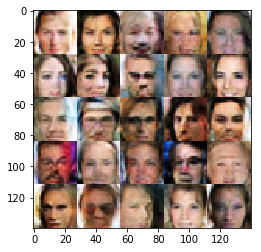

Epoch 1/1:  Discriminator loss = 0.4046  Generator loss = 1.7997
Epoch 1/1:  Discriminator loss = 0.7869  Generator loss = 1.1043
Epoch 1/1:  Discriminator loss = 0.6184  Generator loss = 2.1101
Epoch 1/1:  Discriminator loss = 0.7142  Generator loss = 1.0401
Epoch 1/1:  Discriminator loss = 1.2017  Generator loss = 0.6019
Epoch 1/1:  Discriminator loss = 0.3740  Generator loss = 2.0930
Epoch 1/1:  Discriminator loss = 1.2284  Generator loss = 0.5242
Epoch 1/1:  Discriminator loss = 0.4627  Generator loss = 1.3185
Epoch 1/1:  Discriminator loss = 2.1998  Generator loss = 0.1427
Epoch 1/1:  Discriminator loss = 2.1711  Generator loss = 0.2469


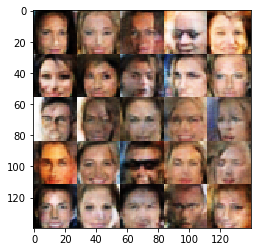

Epoch 1/1:  Discriminator loss = 0.4789  Generator loss = 1.2196
Epoch 1/1:  Discriminator loss = 0.8169  Generator loss = 0.8386
Epoch 1/1:  Discriminator loss = 0.3564  Generator loss = 1.8699


In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.